# Wrangling Data From Bay Area Bike Share Published Data - Trips

### Import Packages

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

<p> Set some notebook variables, makes the notebook 95% width of the screen for easier viewing</p>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<p> Set some global font sizes for plots </p>

In [4]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [5]:
print('Started Loading Station Data...')
file_path_slug = '../source_data/bayareabikeshare/trip.csv'
file_list = glob(file_path_slug)

trips_df = pd.DataFrame()

counter = 1
chunks = []

for file in file_list:
    
    chunk_counter = 1
    num_chunks = math.ceil(sum(1 for row in open(file, 'r'))/10000)
    
    for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
        # define Columns
        chunk.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_terminal', 'end_date', 
                         'end_station_name', 'end_terminal', 'bike_id', 'subscriber_type', 'zip_code']

        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1
        
    print('Finished file! (%d of %d)' % (counter, len(file_list)))
    counter += 1
    
trips_df = pd.concat(chunks)
print('Data Loaded Successfully!')

Started Loading Station Data...
	[22:22:21.635603] finished chunk 1 of 67
	[22:22:21.834571] finished chunk 7 of 67
	[22:22:22.085721] finished chunk 14 of 67
	[22:22:22.324022] finished chunk 21 of 67
	[22:22:22.562904] finished chunk 28 of 67
	[22:22:22.818391] finished chunk 35 of 67
	[22:22:23.181499] finished chunk 42 of 67
	[22:22:23.517025] finished chunk 49 of 67
	[22:22:23.748031] finished chunk 56 of 67
	[22:22:23.994338] finished chunk 63 of 67
	[22:22:24.138787] finished chunk 67 of 67
Finished file! (1 of 1)
Data Loaded Successfully!


## Cleaning Support Functions
<p>General Cleaning functions</p>

In [5]:
def clean_zipcode(item):
    ''' Zipcodes in this data set are self reported rider zipcodes
        and the method of entry for these zipcodes is reported to 
        not be very clear for users, we are using a heavy hand 
        when cleaning up zip codes'''

    zip_string = str(item)
    
    # if zipcode is not 5 characters long
    if len(zip_string) > 5:
        # try splitting on a few different characters

        # split on '-'
        try:
            result = zip_string.split('-')[0]
        except:
            result = zip_string
        
        # split on '.'
        try:
            result = zip_string.split('.')[0]
        except:
            result = zip_string
            
        # take only first 5 characters
        result = result[:5]

        # if len of zipstring is less than 5, return 'NaN'
        if len(result) < 5:
            return 99999

    # if it is 5 characters long, move along
    else:
        result = zip_string
    
    # make sure result is all digits
    if result.isdigit():
        result = int(result)
        return result
    else:
        return 99999


def clean_trip_frame(df):
    '''Basic Cleanup of column types and appends a 'duration_minutes' 
        column converted from given 'duration' which is in seconds'''
    # set column types
    df['start_date']       = pd.to_datetime(df['start_date'], format="%m/%d/%Y %H:%M")
    df['end_date']         = pd.to_datetime(df['end_date'],   format="%m/%d/%Y %H:%M")
    df['trip_id']          = df['trip_id'].astype('int')
    df['duration']         = df['duration'].astype('int')    
    df['start_terminal']   = df['start_terminal'].astype('int')
    df['end_terminal']     = df['end_terminal'].astype('int')
    df['bike_id']          = df['bike_id'].astype('int')
    df['subscriber_type']  = df['subscriber_type'].astype('category')
    
    # add 'duration_minutes' column
    df['duration_minutes'] = df['duration'] / 60.
    df['duration_minutes'] = df['duration_minutes'].astype('float')
    
    # Clean Zipcode
    df['zip_code'] = df.zip_code.apply(clean_zipcode)
    
    # rename columns for clarity
    df.rename(columns={'zip_code': 'user_zip', 'subscriber_type': 'user_type'}, inplace=True)

    return df

## Cleaning Data
<p>Format zip codes to take only first 5 digits, this data is self reported and often wrongly input per Bay Area Bike Share Notes</p>

In [6]:
# clean data frames
print('[%s] Trip Data Cleanup Started' % datetime.datetime.now().time())
trips_df = clean_trip_frame(trips_df)

print('[%s] Cleaning Duplicates and Reindexing Trip Data' % datetime.datetime.now().time())
trips_df.drop_duplicates(inplace=True)
trips_df.sort_values('trip_id', inplace=True)
trips_df.reset_index(inplace=True, drop=True)

print('[%s] Cleanup Complete!' % datetime.datetime.now().time())

[16:04:15.461967] Trip Data Cleanup Started
[16:04:27.303618] Cleaning Duplicates and Reindexing Trip Data
[16:04:29.105499] Cleanup Complete!


In [7]:
trips_df.shape

(983648, 12)

### Prune by Duration
<p>The distribution of trips is heavily left skewed, pruning trips longer than 60 minutes in duration helps get a beter picture of the important data points</p>

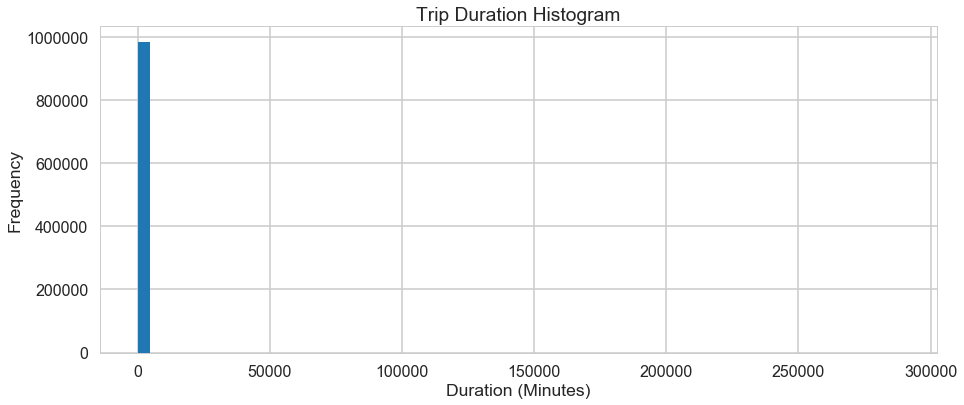

In [8]:
trips_df.duration_minutes.plot(kind='hist', bins=60, figsize=(15,6))
plt.xlabel('Duration (Minutes)')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram')
plt.show()

In [9]:
# prune data to exclude trips longer than 60 minutes
print('[%s] - Removing trips longer than 60 minutes' % (datetime.datetime.now().time()))
drop_list = trips_df[trips_df.duration_minutes > 60.0].index
print('\t\tremoving %s items' % len(drop_list))
trips_df.drop(drop_list, inplace=True)
trips_df.reset_index(inplace=True, drop=True)
print('[%s] - Complete' % (datetime.datetime.now().time()))

[16:04:30.012035] - Removing trips longer than 60 minutes
		removing 28091 items
[16:04:30.297968] - Complete


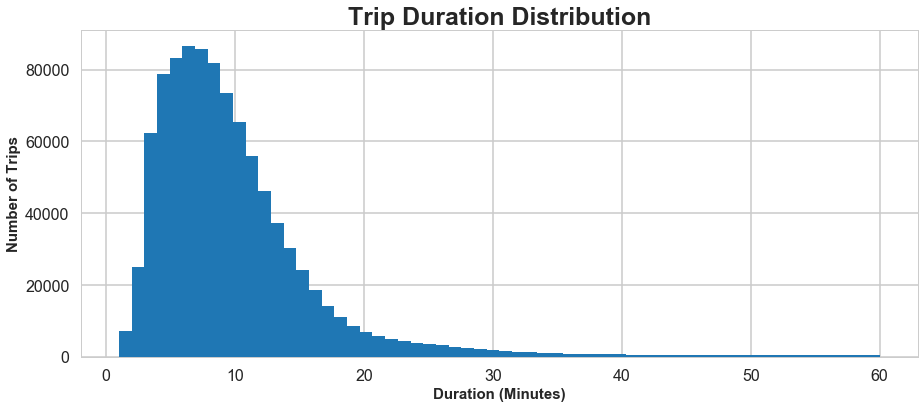

In [10]:
trips_df.duration_minutes.plot(kind='hist', bins=60, figsize=(15,6))
plt.xlabel('Duration (Minutes)', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
plt.title('Trip Duration Distribution', size=TITLE_FONT_SIZE, weight='bold')
plt.savefig('../charts/03_Trip_Duration_Distribution.png')

## Correct Relocated Stations

> There was a delay in station_id updates when stations 23, 24, 25, and 26 were relocated, update status information by changing the station_id for these stations in dates after they were relocated

In [11]:
def plot_terminal_trips(df, id, date_range = (pd.Timestamp('2013-08-01'), pd.Timestamp('2016-10-01')), x_label = 'Date', y_label = 'Trips', title_suffix='', draw_dates=[]):
    '''for each terminal in a trips_df, plot the number of trips starting or finishing at that terminal'''
    def group_terminal(df, start=True):
        ''' group by start or end terminal trips per day
        '''
        
        term = pd.DataFrame()
        if start:
            term = df[df['start_terminal'] == id]
        else:
            term = df[df['end_terminal'] == id]
        term.set_index('start_date', inplace=True)
        g_term = term.groupby(term.index.date)['trip_id'].count()
        
        return g_term
    
        
    start_term = group_terminal(df, start=True)
    end_term   = group_terminal(df, start=False)
    
    ax = start_term.plot(kind='line', color='c', alpha=0.75, figsize=(24,3))
    end_term.plot(kind='line', color='g', alpha=0.75, ax=ax)
    
    ax.set_xlim(date_range)
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    
    ax.legend(['Start Terminal', 'End Terminal'], loc=1)
    
    if len(draw_dates) > 0:
        for xc in draw_dates:
            ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
    plt.show()

def date_fixes(df, old_terminal, new_terminal, change_date):
    '''Correct dates on terminal relocations, outputs graphs for quick validation of before and after'''
    print('[%s]\tUpdating %s to %s for dates after %s' % (datetime.datetime.now().time(), old_terminal, new_terminal, change_date))
    
    for station in [old_terminal, new_terminal]:
        plot_terminal_trips(df, station, title_suffix='PRE DATE FIX', draw_dates=[change_date])
        
    # Fix A to B - Start Terminal
    print('[%s]\tSettings %s to %s occuring before %s' % (datetime.datetime.now().time(), old_terminal, new_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == old_terminal) & (df.start_date >= change_date)].index
    df.loc[index_to_update_start, 'start_terminal'] = new_terminal

    # Fix A to B - End Terminal
    index_to_update_end   = df[(df.end_terminal == old_terminal) & (df.end_date >= change_date)].index
    df.loc[index_to_update_end, 'end_terminal'] = new_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())
    
    # Fix B to A - Start Terminal
    print('[%s]\tSettings %s to %s occuring after %s' % (datetime.datetime.now().time(), new_terminal, old_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == new_terminal) & (df.start_date < change_date)].index
    df.loc[index_to_update_start, 'start_terminal'] = old_terminal

    # Fix B to A - End Terminal
    index_to_update_end   = df[(df.end_terminal == new_terminal) & (df.end_date < change_date)].index
    df.loc[index_to_update_end, 'end_terminal'] = old_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())
    
    for station in [old_terminal, new_terminal]:
        plot_terminal_trips(df, station, draw_dates=[change_date])
    
    return df

[16:04:31.447718]	Updating 23 to 88 for dates after 2016-07-05 00:00:00


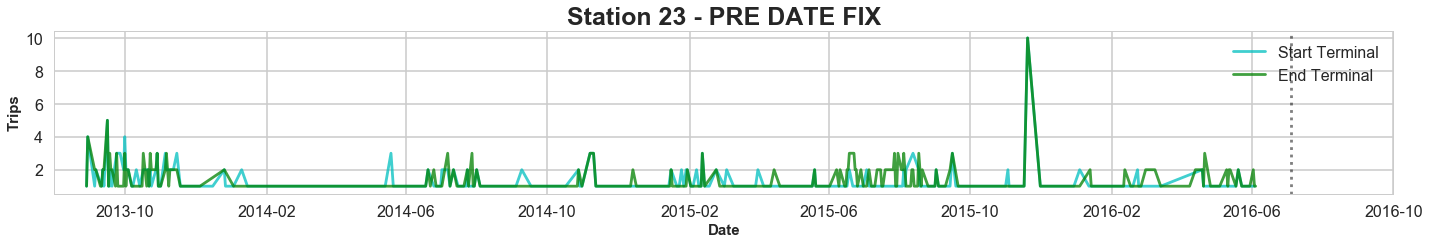

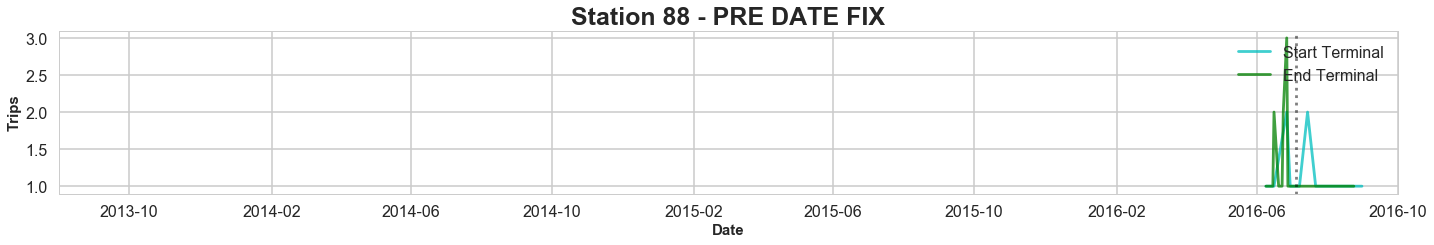

[16:04:32.071288]	Settings 23 to 88 occuring before 2016-07-05 00:00:00
	[16:04:32.269491]	Complete!
[16:04:32.269821]	Settings 88 to 23 occuring after 2016-07-05 00:00:00
	[16:04:32.387608]	Complete!


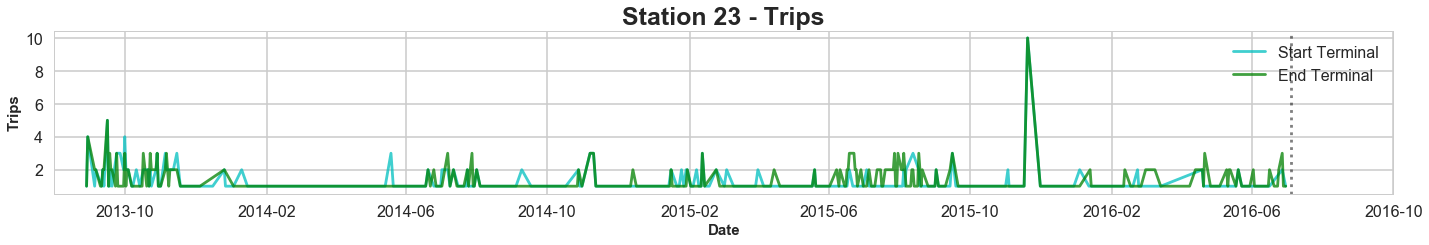

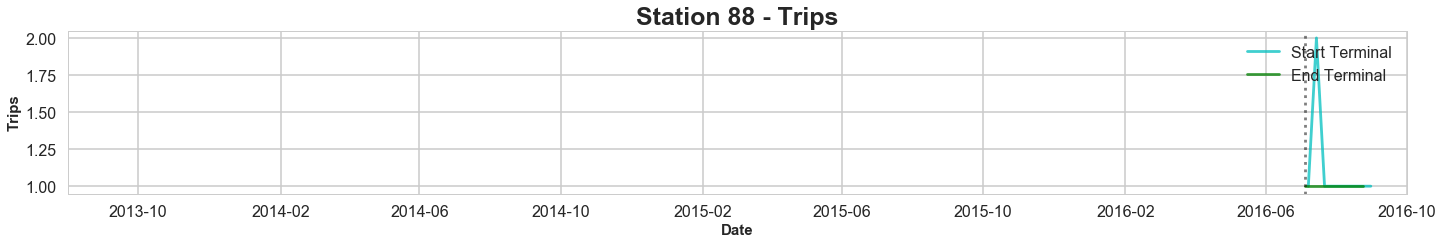

[16:04:33.124121]	Updating 24 to 89 for dates after 2016-07-05 00:00:00


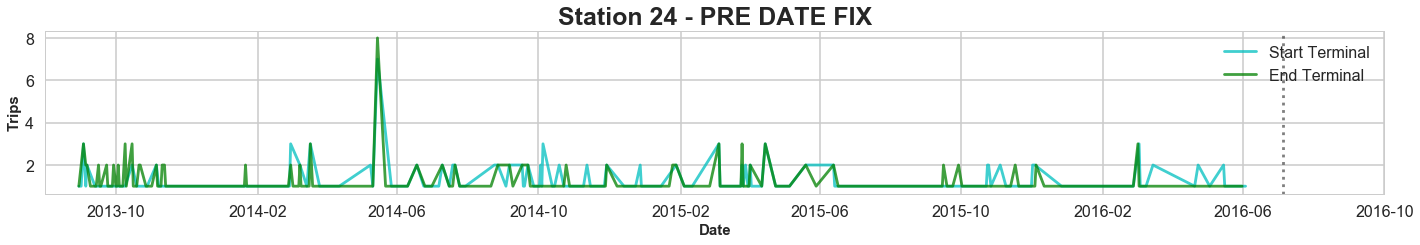

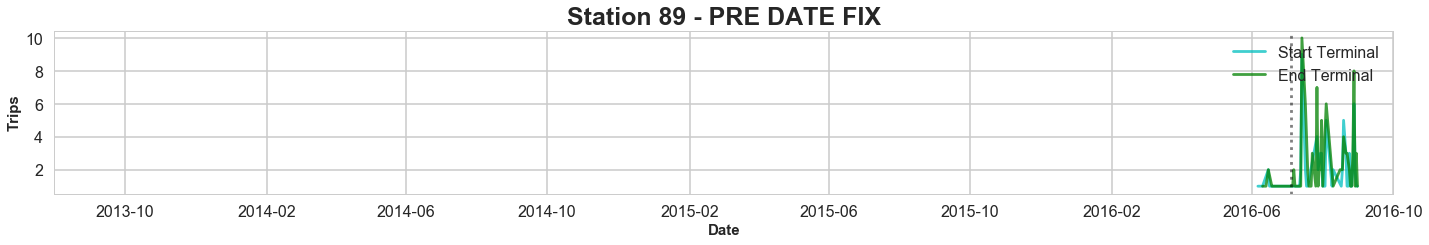

[16:04:33.929656]	Settings 24 to 89 occuring before 2016-07-05 00:00:00
	[16:04:34.025828]	Complete!
[16:04:34.025991]	Settings 89 to 24 occuring after 2016-07-05 00:00:00
	[16:04:34.112962]	Complete!


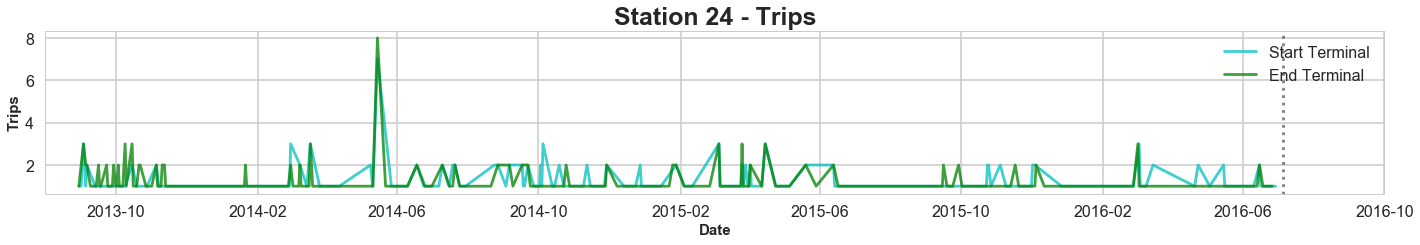

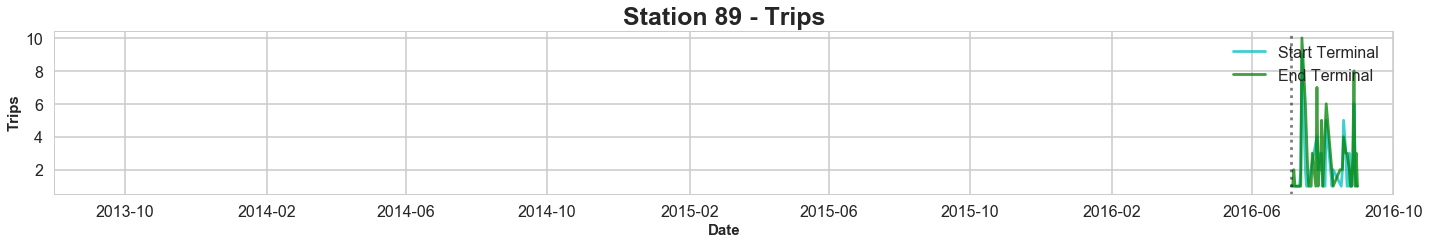

In [12]:
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 23, 88, change_date)
trips_df = date_fixes(trips_df, 24, 89, change_date)

[16:04:35.453961]	Updating 25 to 91 for dates after 2016-08-04 00:00:00


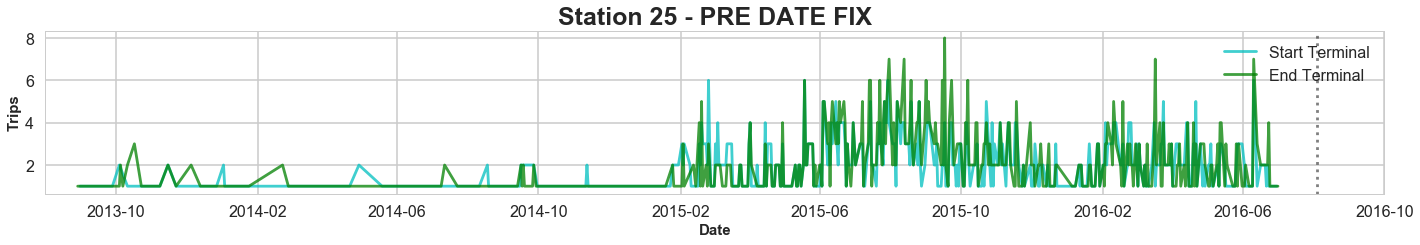

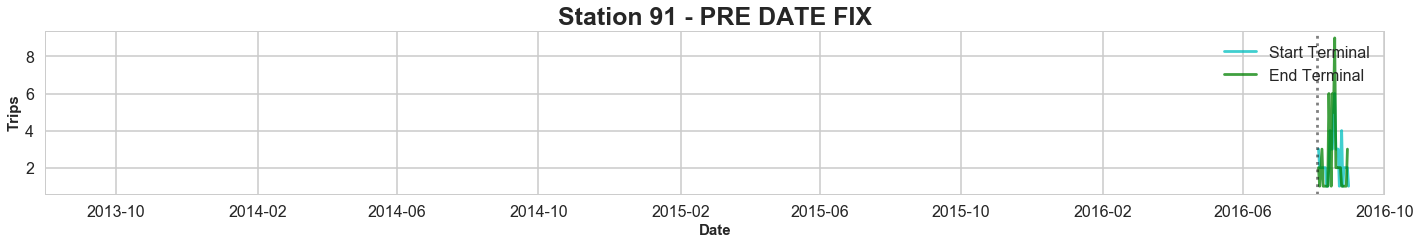

[16:04:36.336117]	Settings 25 to 91 occuring before 2016-08-04 00:00:00
	[16:04:36.450859]	Complete!
[16:04:36.451050]	Settings 91 to 25 occuring after 2016-08-04 00:00:00
	[16:04:36.553019]	Complete!


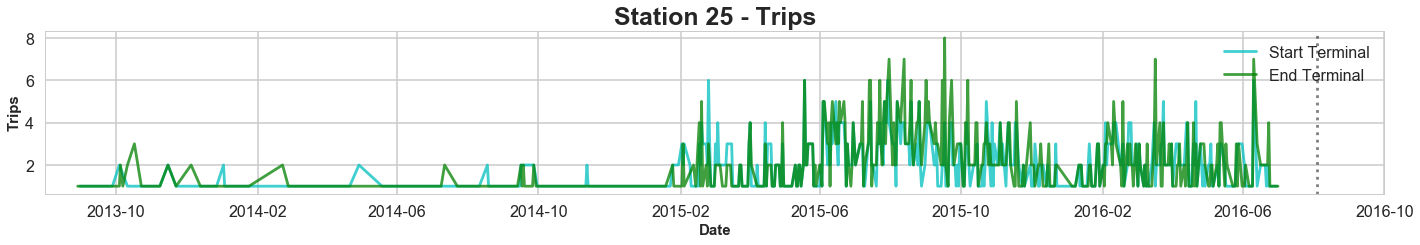

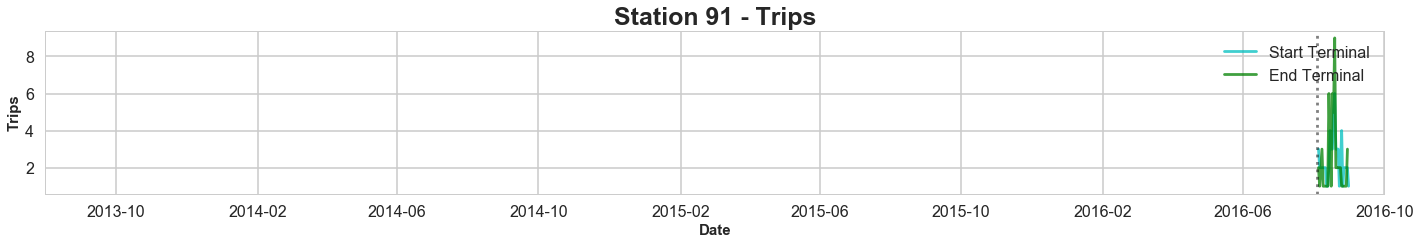

[16:04:37.325877]	Updating 26 to 90 for dates after 2016-08-04 00:00:00


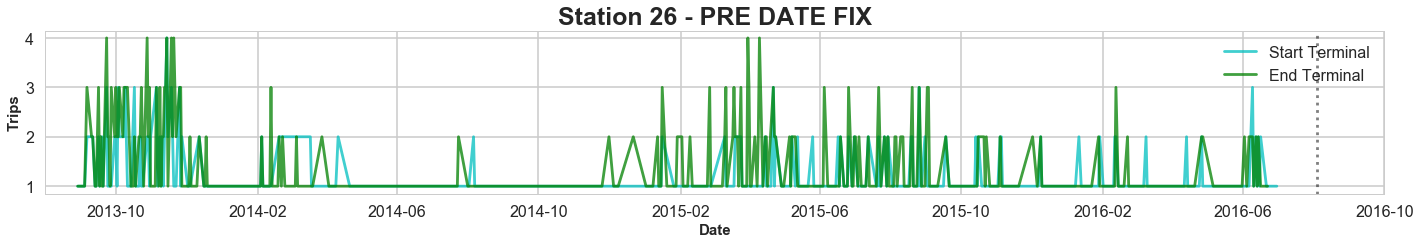

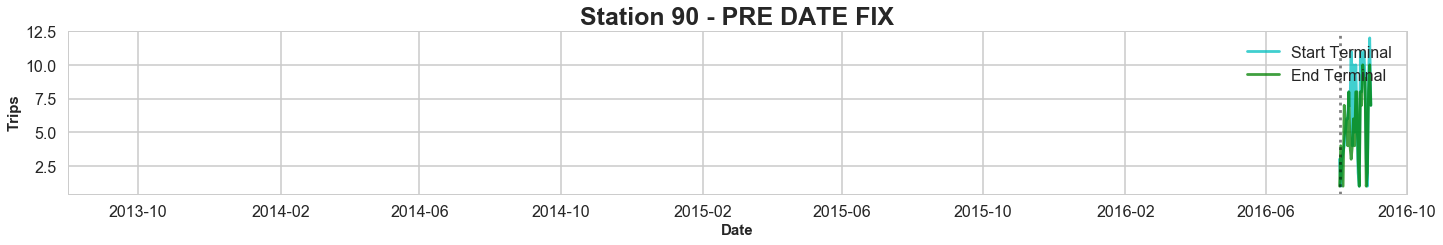

[16:04:38.098408]	Settings 26 to 90 occuring before 2016-08-04 00:00:00
	[16:04:38.201192]	Complete!
[16:04:38.201344]	Settings 90 to 26 occuring after 2016-08-04 00:00:00
	[16:04:38.296277]	Complete!


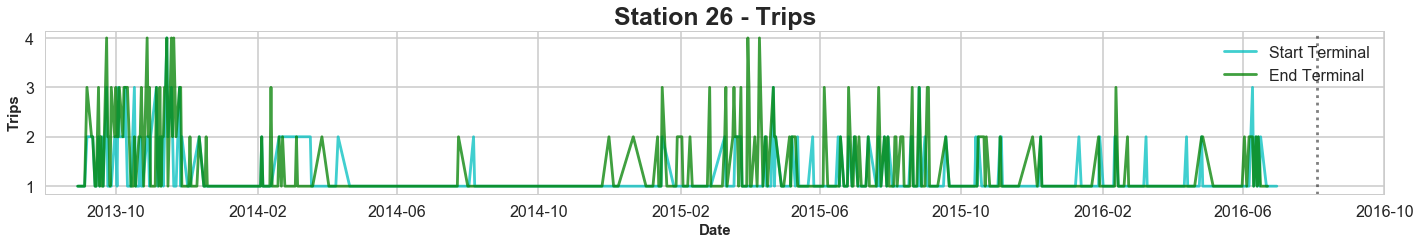

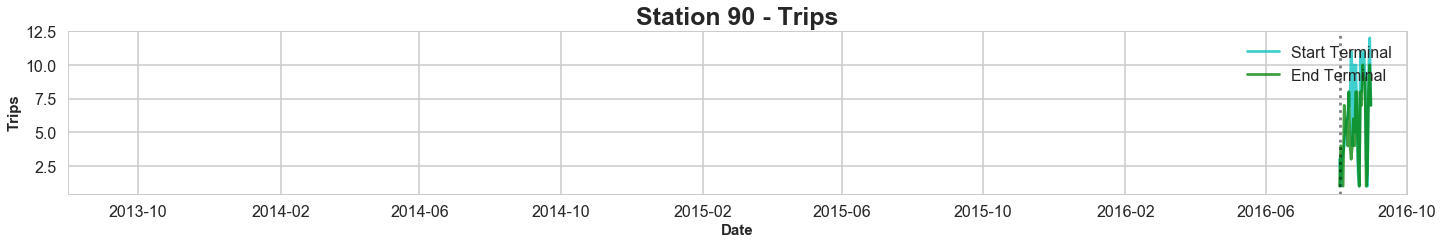

In [13]:
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 25, 91, change_date)
trips_df = date_fixes(trips_df, 26, 90, change_date)

# Write Data to File - Basic Trip Data

In [14]:
trips_df.to_csv('../clean_data/bayareabikeshare/trip_data_cleaned.csv', encoding='utf-8')

In [15]:
trips_df.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,18.616667
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,18.633333


# Append Station and Weather Data to Trips

### Load Station and Weather Data

In [16]:
# load Station Data
stations_df = pd.DataFrame()
stations_df = pd.read_csv('../clean_data/bayareabikeshare/station_data_cleaned.csv', index_col=0, parse_dates=['first_service_date', 'last_service_date'])
stations_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098


In [17]:
# load weather data
weather_df = pd.DataFrame()
weather_df = pd.read_csv('../clean_data/bayareabikeshare/weather_data_cleaned.csv', parse_dates=['date'], index_col=0)
weather_df.set_index('date', drop=True)
weather_df.head()

,date,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events,zip_code
0,2013-08-29,80.0,70.0,64.0,16.0,5.0,16.0,0.0,4.0,NaN,94041
1,2013-08-29,80.0,71.0,62.0,14.0,6.0,17.0,0.0,5.0,NaN,94063
2,2013-08-29,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN,94107
3,2013-08-29,78.0,71.0,64.0,20.0,8.0,23.0,0.0,4.0,NaN,94301
4,2013-08-29,81.0,72.0,63.0,16.0,7.0,24.0,0.0,4.0,NaN,95113


### Append Data to Trips

In [18]:
print('trips_df.shape\t\t%s\t%s' % (trips_df.shape[0], trips_df.shape[1]))
print('stations_df.shape\t%s\t%s' % (stations_df.shape[0], stations_df.shape[1]))
print('weather_df.shape\t%s\t%s' % (weather_df.shape[0], weather_df.shape[1]))

trips_df.shape		955557	12
stations_df.shape	79	10
weather_df.shape	5495	11


In [19]:
# append Station Data to Trips
print('[%s]\tAppending Start Area & Zip Lookup...' % datetime.datetime.now().time())

# append start_zip
trips_df = pd.merge(trips_df, 
                  stations_df[['station_id', 'zip_code']], 
                  how='left', 
                  left_on=[trips_df.start_terminal], 
                  right_on=[stations_df.station_id])

trips_df.drop(['station_id'], axis=1, inplace=True)
trips_df.rename(columns={'zip_code':'start_zip'}, inplace=True)

# append end_zip
trips_df = pd.merge(trips_df, 
                  stations_df[['station_id', 'zip_code']], 
                  how='left', 
                  left_on=[trips_df.end_terminal], 
                  right_on=[stations_df.station_id])

trips_df.drop(['station_id'], axis=1, inplace=True)
trips_df.rename(columns={'zip_code':'end_zip'}, inplace=True)

print('[%s]\tComplete!' % datetime.datetime.now().time())

[16:04:56.571241]	Appending Start Area & Zip Lookup...
[16:04:58.911305]	Complete!


In [20]:
trips_df.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes,start_zip,end_zip
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000,94107,94107
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333,94107,94107
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000,94107,94107
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,18.616667,94107,94107
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,18.633333,94107,94107


In [21]:
print('[%s]\tAppending Weather Data...' % datetime.datetime.now().time())

trips_complete_df = pd.merge(trips_df, 
                          weather_df, 
                          how='left', 
                          left_on=[trips_df['start_date'].dt.date, 'start_zip'], 
                          right_on=[weather_df.date.dt.date, 'zip_code'])
trips_complete_df.drop(['zip_code', 'date'], axis=1, inplace=True)

print('\t[%s]\tComplete!' % datetime.datetime.now().time())

[16:04:58.981668]	Appending Weather Data...
	[16:05:07.400915]	Complete!


In [22]:
trips_complete_df.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [23]:
trips_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998523 entries, 0 to 998522
Data columns (total 23 columns):
trip_id               998523 non-null int64
duration              998523 non-null int64
start_date            998523 non-null datetime64[ns]
start_station_name    998523 non-null object
start_terminal        998523 non-null int64
end_date              998523 non-null datetime64[ns]
end_station_name      998523 non-null object
end_terminal          998523 non-null int64
bike_id               998523 non-null int64
user_type             998523 non-null category
user_zip              998523 non-null int64
duration_minutes      998523 non-null float64
start_zip             998523 non-null int64
end_zip               998523 non-null int64
max_temp              998458 non-null float64
mean_temp             998458 non-null float64
min_temp              998458 non-null float64
max_wind              998518 non-null float64
mean_wind             998518 non-null float64
max_gust          

# Write Data to File - Complete Trip Data

In [24]:
trips_complete_df.to_csv('../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv', encoding='utf-8')

***
# Preview EDA of Stations Data

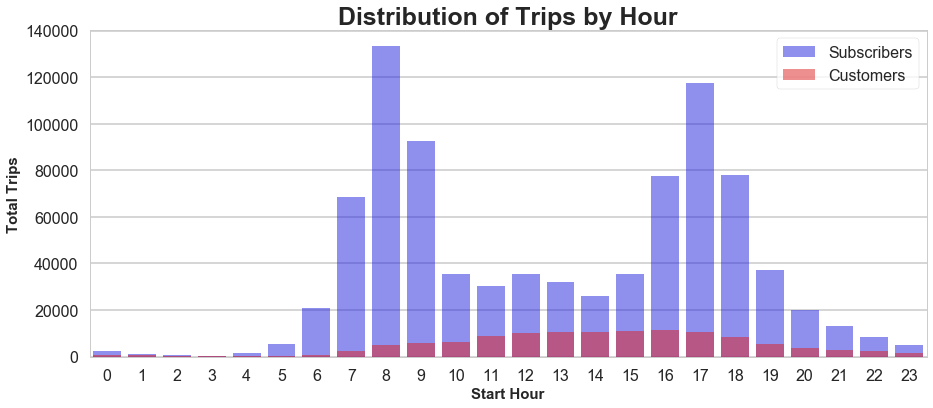

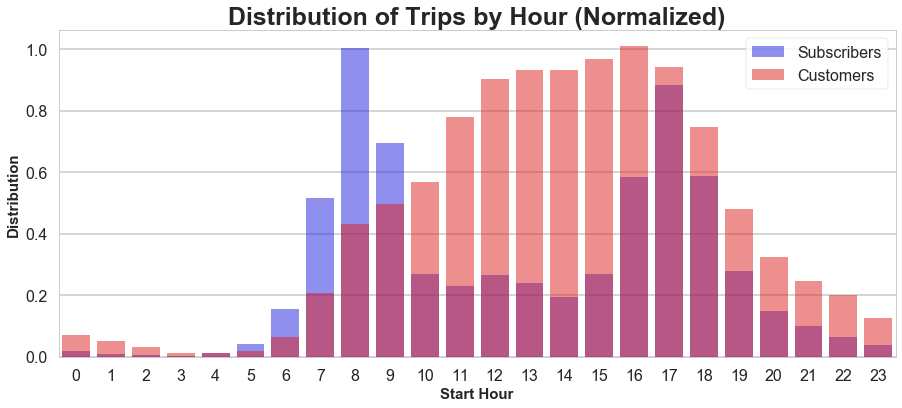

In [25]:
x_ticks = sorted(pd.unique(trips_complete_df.start_date.dt.hour))
subscriber_y = trips_complete_df[trips_complete_df.user_type == 'Subscriber'].groupby(trips_complete_df.start_date.dt.hour)['trip_id'].count()
customer_y   = trips_complete_df[trips_complete_df.user_type == 'Customer'].groupby(trips_complete_df.start_date.dt.hour)['trip_id'].count()
sub_norm  = subscriber_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))
cust_norm =   customer_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))

# Trips by Hour by Customer Type
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = subscriber_y, color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = customer_y, color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)

plt.legend(loc=1, frameon=True)
plt.savefig('../charts/03_Trips_Per_Hour.png')


# Normalized Trips by Hour by Customer Type
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = sub_norm['trip_id'], color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = cust_norm['trip_id'], color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour (Normalized)', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Distribution', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)

plt.legend(loc=1, frameon=True)
plt.savefig('../charts/03_Trips_Per_Hour_Noramlized.png')


# Quick Reference to some 'Special Stations'
<p>Some stations were relocated, closed, or expanded during the program's recorded dataset being used in this analysis, this is a quick view to these notable stations</p>
<ul>
    <li> Station 21 - Relocated on September 16, 2015
    <li> Station 30 - Relocated on September 28, 2015
    <li> Station 33 - Relocated on September 16, 2015
    <li> Station 73 - Relocated on March 14, 2016 and May 19, 2016 had 4 extra docks added
</ul>

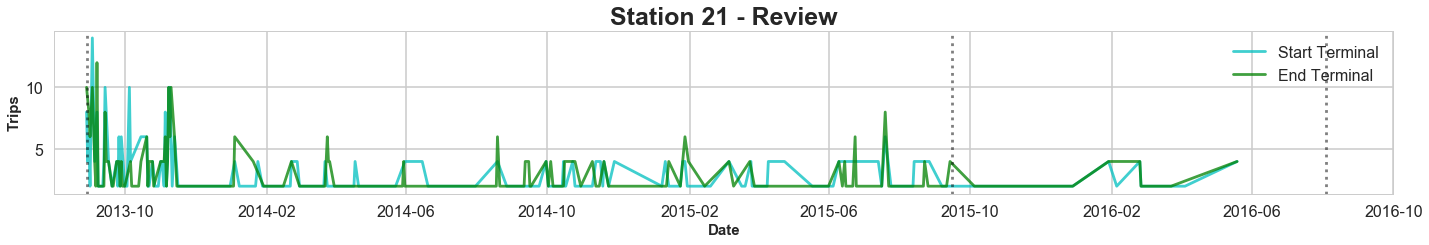

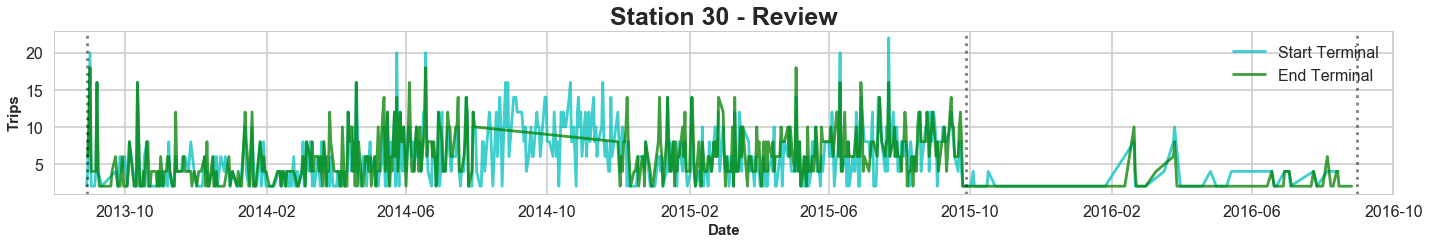

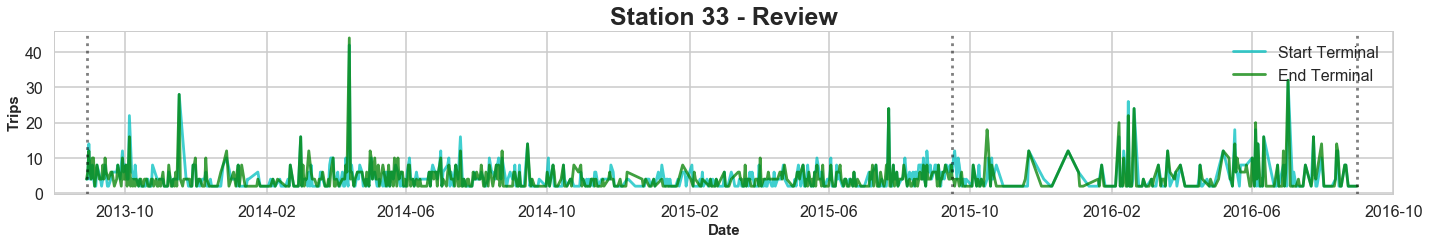

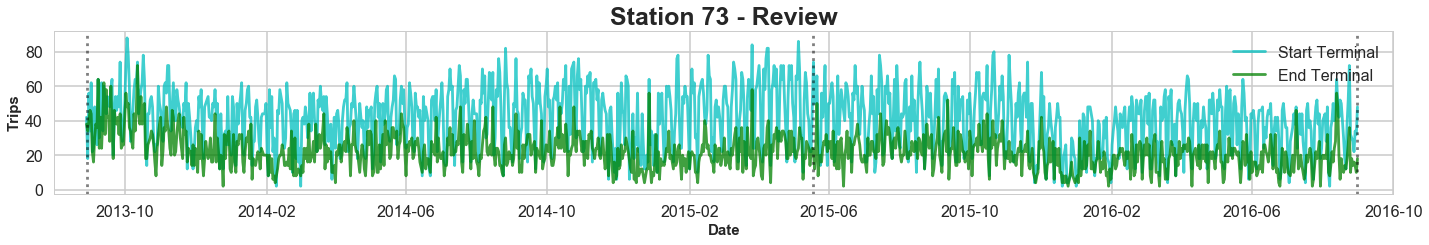

In [26]:
# Station 21 Review
s21_dates = ['2013-08-29', '2015-09-16', '2016-08-04']
plot_terminal_trips(trips_df, 21, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s21_dates)

# Station 30 Review
s30_dates = ['2013-08-29', '2015-09-28', '2016-08-31']
plot_terminal_trips(trips_df, 30, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s30_dates)

# Station 33 Review
s33_dates = ['2013-08-29', '2015-09-16', '2016-08-31']
plot_terminal_trips(trips_df, 33, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s33_dates)

# Station 73 Review
s73_dates = ['2013-08-29', '2015-05-19', '2016-08-31']
plot_terminal_trips(trips_df, 73, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s73_dates)